# Import Library

In [1]:
!pip install BeautifulSoup4

     |████████████████████████████████| 115 kB 1.2 MB/s 


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import nltk
from nltk.corpus import stopwords
from bs4 import BeautifulSoup as bs
import seaborn as sns
import re
import torch
import torch.nn as nn
import torchtext
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import Vocab
from collections import Counter
import matplotlib as mpl
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

In [3]:
is_cuda = torch.cuda.is_available()
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU is available


In [4]:
from cycler import cycler


raw_light_palette = [
    (0, 122, 255), # Blue
    (255, 149, 0), # Orange
    (52, 199, 89), # Green
    (255, 59, 48), # Red
    (175, 82, 222),# Purple
    (255, 45, 85), # Pink
    (88, 86, 214), # Indigo
    (90, 200, 250),# Teal
    (255, 204, 0)  # Yellow
]

raw_dark_palette = [
    (10, 132, 255), # Blue
    (255, 159, 10), # Orange
    (48, 209, 88),  # Green
    (255, 69, 58),  # Red
    (191, 90, 242), # Purple
    (94, 92, 230),  # Indigo
    (255, 55, 95),  # Pink
    (100, 210, 255),# Teal
    (255, 214, 10)  # Yellow
]

raw_gray_light_palette = [
    (142, 142, 147),# Gray
    (174, 174, 178),# Gray (2)
    (199, 199, 204),# Gray (3)
    (209, 209, 214),# Gray (4)
    (229, 229, 234),# Gray (5)
    (242, 242, 247),# Gray (6)
]

raw_gray_dark_palette = [
    (142, 142, 147),# Gray
    (99, 99, 102),  # Gray (2)
    (72, 72, 74),   # Gray (3)
    (58, 58, 60),   # Gray (4)
    (44, 44, 46),   # Gray (5)
    (28, 28, 39),   # Gray (6)
]


light_palette = np.array(raw_light_palette)/255
dark_palette = np.array(raw_dark_palette)/255
gray_light_palette = np.array(raw_gray_light_palette)/255
gray_dark_palette = np.array(raw_gray_dark_palette)/255

mpl.rcParams['axes.prop_cycle'] = cycler('color',dark_palette)
mpl.rcParams['figure.facecolor']  = gray_dark_palette[-2]
mpl.rcParams['figure.edgecolor']  = gray_dark_palette[-2]
mpl.rcParams['axes.facecolor'] =  gray_dark_palette[-2]

white_color = gray_light_palette[-2]
mpl.rcParams['text.color'] = white_color
mpl.rcParams['axes.labelcolor'] = white_color
mpl.rcParams['axes.edgecolor'] = white_color
mpl.rcParams['xtick.color'] = white_color
mpl.rcParams['ytick.color'] = white_color

mpl.rcParams['figure.dpi'] = 100

mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.right'] = False

- reference : https://www.kaggle.com/subinium/dark-mode-visualization-apple-version

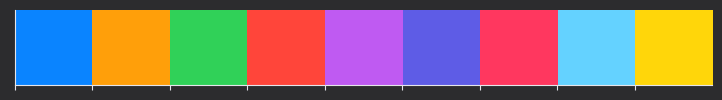

In [5]:
sns.palplot(dark_palette)

# Data Load

In [6]:
train = pd.read_csv('/kaggle/input/cse4302/cse4302_train.tsv', sep='\t')
test = pd.read_csv('/kaggle/input/cse4302/cse4302_test.tsv', sep='\t')
submission = pd.read_csv('/kaggle/input/cse4302/sampleSubmission.csv')

In [7]:
train.shape

(15000, 2)

In [8]:
test.shape

(35000, 1)

Train data length is 15000. But test data length is 35000.  
So data imbalacing is too big. We need to Data augmentation.

# Data check

In [9]:
train.head()

,review,sentiment
0,for whoever play games video games here did an...,positive
1,Pola X is a beautiful adaption of Herman Melvi...,positive
2,TOM HULCE* turns in yet another Oscar-worthy p...,positive
3,I've seen this movie and I must say I'm very i...,positive
4,"To me, this review may contain spoilers, but I...",positive


In [10]:
test.head()

,review
0,"Well,I am a dancer so automatically I liked th..."
1,Hal Hartley has been likened to a modern day W...
2,I remember seeing this film when I was fairly ...
3,During my teens or should I say prime time I w...
4,Is the Cannes controversy-meter remarkably eso...


# Data EDA

In [11]:
reviews = list(train['review'])

Get the review data for processing the review data corpous.

## sentence tokenizing

In [12]:
# review string list tokenizing
tokenized_review = [r.split() for r in reviews]

# save the tokenizing list length
review_len_by_token = [len(t) for t in tokenized_review]

# save wording
review_len_by_alphabet = [len(s.replace(' ', '')) for s in reviews]

## Data length distribution check

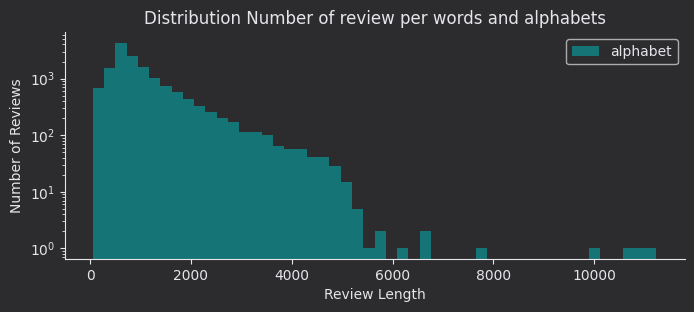

In [13]:
plt.figure(figsize=(8, 3))
plt.hist(review_len_by_alphabet, bins=50, alpha=0.5, color='c', label='alphabet')
plt.yscale('log', nonpositive='clip')

plt.title('Distribution Number of review per words and alphabets')
plt.xlabel('Review Length')
plt.ylabel('Number of Reviews')
plt.legend()
plt.show()

First, We can see almost review data length is under 6000 and under 2000 data is most.  
Second, Some outlier exists. Outlier data is over 10000.

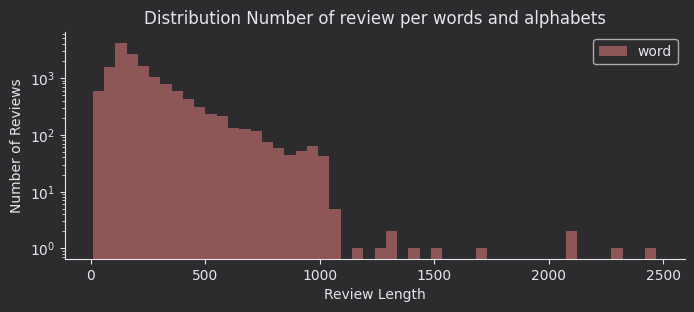

In [14]:
plt.figure(figsize=(8, 3))
plt.hist(review_len_by_token, bins=50, alpha=0.5, color='lightcoral', label='word')
plt.yscale('log', nonpositive='clip')

plt.title('Distribution Number of review per words and alphabets')
plt.xlabel('Review Length')
plt.ylabel('Number of Reviews')
plt.legend()
plt.show()

We can check almost data has under 1000 words and alomost has 200 words.

This histogram show number of review data per number of word and number of alphabet.
We need to find the outlier.

## Check Outlier

### Outlier distribution

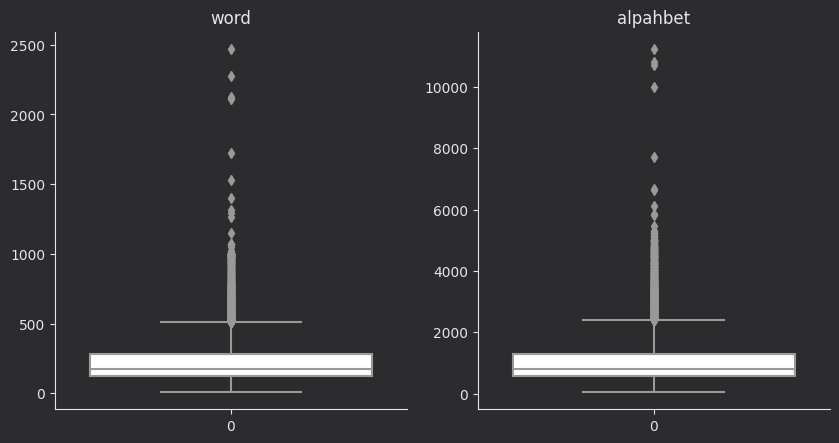

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

sns.boxplot(data=review_len_by_token, ax=axes[0], color='white')
axes[0].set_title('word')
sns.boxplot(data=review_len_by_alphabet, ax=axes[1], color='white')
axes[1].set_title('alpahbet')
plt.show()

We can check too many outliers.  
Let's check the data by wordcloud.

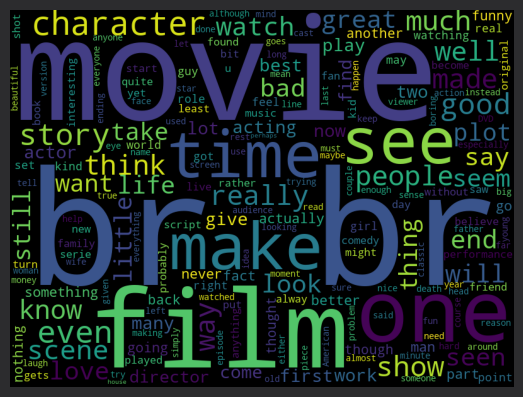

In [16]:
from wordcloud import WordCloud, STOPWORDS

wordcloud = WordCloud(stopwords=STOPWORDS, background_color='black', width=800, height=600).generate(' '.join(train['review']))

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [17]:
train['review'][1]

"Pola X is a beautiful adaption of Herman Melville's 'Pierre; or, the Ambiguities'. The comments on here surprise me, it makes me wonder what has led to the overwhelmingly negative reaction. <br /><br />The shock value is the least appealing thing about this film - a minor detail that has been blown out of proportion. The story is of Pierre's downfall - and the subsequent destruction of those around him - which is overtly demonstrated in his features, demeanour and idiolect. The dialogue and soundtrack set this film apart from any other I have seen, and turn a fundamentally traditional storyline with controversial twists into an unforgettably emotional epic.<br /><br />I can't stress enough the importance of disregarding everything you have heard about this film and watching, as I did, with an open mind. You will, I hope, be rewarded in the same way that I was. I felt on edge and nervous from around the half-hour mark, however the film is far from scary in any traditional sense. It wil

This data is movie review data. So we can understand why movie and film is frequently data.  
But what is 'br'?  
'br' mean \<br\> tag.  
I think like tags word make outlier data.

## Check label distribution

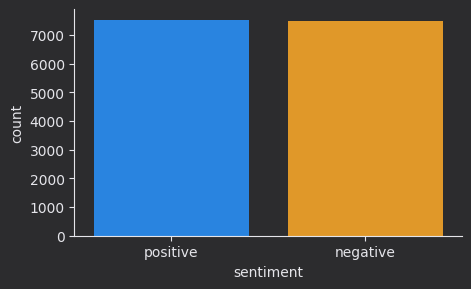

Positivie review : 7483
Negativie review : 7517


In [18]:
fig, ax = plt.subplots(figsize=(5, 3))
sns.countplot(data=train, x='sentiment', ax=ax)
plt.show()

print('Positivie review : {}'.format(train['sentiment'].value_counts()[1]))
print('Negativie review : {}'.format(train['sentiment'].value_counts()[0]))

We can check label is balancing data.

# Data preprocessing

In [19]:
def preprocessing(review, remove_stopwords=False):
    review_text = bs(review, 'html5lib').get_text()
    review_text = re.sub('[^a-zA-Z]', ' ', review_text)
    words = review_text.lower().split()
    
    if remove_stopwords:
        stops = set(stopwords.words('english'))
        words = [w for w in words if not w in stops]
        clean_review = ' '.join(words)
    else:
        clean_review = ' '.join(words)
        
    return clean_review

In [20]:
clean_train_reviews = []

for review in train['review']:
    clean_train_reviews.append(preprocessing(review, True))
    
clean_test_reviews = []

for review in test['review']:
    clean_test_reviews.append(preprocessing(review, True))

In [21]:
clean_train_df = pd.DataFrame({'review':clean_train_reviews, 'sentiment':train['sentiment']})
clean_test_df = pd.DataFrame({'review':clean_test_reviews})

In [22]:
import tensorflow as tf
from tensorflow import keras
from keras.callbacks import EarlyStopping,ModelCheckpoint
from keras.utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding,Conv1D,LSTM,GRU,BatchNormalization,Flatten,Dense

## Data split and make DataSet , DataLoader

In [23]:
clean_train_df['sentiment'] = (clean_train_df['sentiment'] == 'positive').astype(int)

In [24]:
x_train, y_train = clean_train_df['review'], clean_train_df['sentiment']
x_test = clean_test_df['review']

In [25]:
num_words=80000
embeddings=256

In [26]:
tokenizer=Tokenizer(num_words=num_words,oov_token='<OOV>')
tokenizer.fit_on_texts(x_train)
word_index=tokenizer.word_index
total_vocab=len(word_index)

In [27]:
print("Vocabulary of the dataset is : ",total_vocab)

Vocabulary of the dataset is :  61997


In [28]:
sequences_train=tokenizer.texts_to_sequences(x_train)
sequences_test=tokenizer.texts_to_sequences(x_test)

max_len=max(max([len(x) for x in sequences_train]),max([len(x) for x in sequences_test]))

train_padded=pad_sequences(sequences_train,maxlen=max_len)
test_padded=pad_sequences(sequences_test,maxlen=max_len)

In [29]:
X_train,X_val,Y_train,Y_val=train_test_split(train_padded,y_train,
                                             test_size=0.05,random_state=10)

# Modeling

## RNN Model

In [30]:
model= keras.Sequential()
model.add(Embedding(num_words,embeddings,input_length=max_len))
model.add(Conv1D(256,10,activation='relu'))
model.add(keras.layers.Bidirectional(LSTM(128,return_sequences=True)))
model.add(LSTM(64))
model.add(keras.layers.Dropout(0.4))
model.add(Dense(2,activation='softmax'))

In [31]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 1416, 256)         20480000  
_________________________________________________________________
conv1d (Conv1D)              (None, 1407, 256)         655616    
_________________________________________________________________
bidirectional (Bidirectional (None, 1407, 256)         394240    
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                82176     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 2)                 130       
Total params: 21,612,162
Trainable params: 21,612,162
Non-trainable params: 0
____________________________________________

In [32]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy']
             )

In [33]:
es= EarlyStopping(monitor='val_accuracy',
                  patience=2
                 )

checkpoints=ModelCheckpoint(filepath='./',
                            monitor="val_accuracy",
                            verbose=0,
                            save_best_only=True
                           )

callbacks=[es,checkpoints]

In [34]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [35]:
history=model.fit(X_train,Y_train,validation_data=(X_val,Y_val),epochs=5,callbacks=callbacks)

Epoch 1/5
446/446 [==============================] - 234s 508ms/step - loss: 0.5176 - accuracy: 0.7325 - val_loss: 0.5032 - val_accuracy: 0.7560
Epoch 2/5
446/446 [==============================] - 225s 504ms/step - loss: 0.2034 - accuracy: 0.9242 - val_loss: 0.3559 - val_accuracy: 0.8640
Epoch 3/5
446/446 [==============================] - 225s 505ms/step - loss: 0.0480 - accuracy: 0.9855 - val_loss: 0.5327 - val_accuracy: 0.8173
Epoch 4/5
446/446 [==============================] - 225s 504ms/step - loss: 0.0153 - accuracy: 0.9958 - val_loss: 0.6629 - val_accuracy: 0.8493


In [36]:
pred = model.predict(test_padded)

In [37]:
submission['category'] = np.argmax(pred, axis=1)
submission

,id,category
0,1,1
1,2,1
2,3,1
3,4,1
4,5,0
...,...,...
34995,34996,1
34996,34997,1
34997,34998,1
34998,34999,0


In [38]:
submission.to_csv('submission.csv', index=False)